This notebook tests the ability to determine if a highway blocks the direct path between any house and any park

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 681.1 kB/s eta 0:00:00


In [3]:
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas
import folium
import numpy as np
from pyproj import Geod
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import nearest_points

In [4]:
# URL from GitHub
url = 'https://raw.githubusercontent.com/cbarnes5/DATA606CapstoneProject/main/finalcsv.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(url, index_col = 0)

In [5]:
df.head()

,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE
0,2024-04-10,Condo/Co-op,1024 N Utah St #223,Arlington,VA,22201.0,405000.0,1.0,1.0,WESTVIEW AT BALLSTON METRO,698.0,NaN,2005.0,522.0,38.882841,-77.114088
1,2024-03-29,Single Family Residential,4717 26th St N,Arlington,VA,22207.0,1600000.0,3.0,3.0,SHIRLEY WOODS,3812.0,17424.0,1937.0,0.0,38.902593,-77.127983
2,2024-03-14,Condo/Co-op,1029 N Stuart St N #216,Arlington,VA,22201.0,415951.0,1.0,1.0,SUMMERWALK I&II,714.0,NaN,1985.0,407.0,38.883113,-77.111557
3,2024-05-02,Condo/Co-op,851 N Glebe Rd #103,Arlington,VA,22203.0,450000.0,1.0,1.0,CONTINENTAL,752.0,NaN,2003.0,419.0,38.881249,-77.114559
4,2024-05-03,Single Family Residential,4224 23rd St N,Arlington,VA,22207.0,2100000.0,5.0,4.5,LORCOM GROVE,5694.0,6686.0,2007.0,0.0,38.900693,-77.113437


We first need to build a graph that contains are places of interest

In [6]:
places = ["Washington, DC, USA", "Arlington, Virginia, USA", "Alexandria, Virginia, USA"] #Our places of interest. This cell has about a 3m runtime
graphs = [ox.graph_from_place(place, network_type='walk') for place in places]
G_combined = nx.compose_all(graphs)

We get the greenspace tags and highway tags from OSM

In [7]:
#Tags we're using
greenspace_tags = {'leisure': ['park', 'garden', 'nature_reserve']}
highway_tags = {'highway': ['motorway']}

# Function to get nodes from a place based on tags
def get_nodes_from_place(place, tags):
    return ox.features_from_place(place, tags)

# Function to put tag's lat/longs in a list
# Coords outputs Point locaitons (for metro)
# Nodes_combined outputs a dataframe with Points/Polygons/Multipolygon geometric objects (for greenspaces)
def get_lat_longs(tags):
  nodes = []
  for place in places:
    nodes.append(get_nodes_from_place(place, tags))
  nodes_combined = pd.concat(nodes)
  coords = nodes_combined[nodes_combined.geom_type == 'Point'].geometry.apply(lambda geom: (geom.y, geom.x)).tolist()
  return coords, nodes_combined

#call the function for each group
greenspace_coords, nodes_combined_green = get_lat_longs(greenspace_tags)
hw_coords, nodes_combined_hw = get_lat_longs(highway_tags)

In [8]:
print("Number of Greenspace Coordinates:")
print(len(nodes_combined_green))
print("Number of Highway Coordinates:")
print(len(nodes_combined_hw))

Number of Greenspace Coordinates:
2249
Number of Highway Coordinates:
952


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualize all the highway data:

In [9]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_hw["geometry"]).add_to(m)
#folium.GeoJson(nodes_combined_green["geometry"].apply(lambda x: x.centroid)).add_to(m)
m

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


###Cleaning the greenspace data:

In [10]:
#clean nodes_combined_green
nodes_combined_green=nodes_combined_green[['geometry','leisure']]

#remove Point parks
nodes_combined_green=nodes_combined_green[nodes_combined_green.geom_type.isin(['Polygon', 'MultiPolygon'])]
print(len(nodes_combined_green))

#Fix Park 1685 (See Large_Park_Exploration notebook)

#convert multipolygon into list of lists
geom=nodes_combined_green.iloc[1685,0]
mycoordslist = [list(x.exterior.coords) for x in geom.geoms]
#remove parts of the polygon that are west of latitude -77.118427
newcoordslist = []
for coords in mycoordslist:
  lst1 = []
  for coord in coords:
    if coord[0] > -77.118427:
      lst1.append(coord)
  newcoordslist.append(lst1)
#clean new list
newcoordslist = [x for x in newcoordslist if x != []]
# Recreate the polygons
polygons = [Polygon(coords) for coords in newcoordslist]
# Create a MultiPolygon from the polygons
multipolygon = MultiPolygon(polygons)
#replace Park 1685's polygon with this polygon
nodes_combined_green.iloc[1685,0]=multipolygon

#remove parks that are far outside DC-metro boarders
nodes_combined_green.drop(nodes_combined_green.index[[1726, 1696, 1729, 1964]], inplace=True) #See Large_Park_Exploration notebook for explanation of index choice
print(len(nodes_combined_green))

#add center coords
nodes_combined_green['centercoords'] = nodes_combined_green.geometry.apply(lambda geom: (geom.centroid.y, geom.centroid.x)).tolist()

#clean the greenspace nodes combined dataframe
nodes_combined_green.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2159
2155


In [11]:
#clean nodes_combined_green
nodes_combined_green=nodes_combined_green[['geometry','leisure']]

#remove Point parks
nodes_combined_green=nodes_combined_green[nodes_combined_green.geom_type.isin(['Polygon', 'MultiPolygon'])]
print(len(nodes_combined_green))

#add center coords
nodes_combined_green['centercoords'] = nodes_combined_green.geometry.apply(lambda geom: (geom.centroid.y, geom.centroid.x)).tolist()

#clean the greenspace nodes combined dataframe
nodes_combined_green.reset_index(drop=True, inplace=True)

2155


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
#Add area to nodes_combined_green using geodesic area

geod = Geod(ellps="WGS84")
area_sqmeters = []

for x in range(0, len(nodes_combined_green)):
  poly= nodes_combined_green.geometry[x]
  geod_area = abs(geod.geometry_area_perimeter(poly)[0])
  area_sqmeters.append(geod_area)

nodes_combined_green['area_sq'] = area_sqmeters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###We will use the National Arboritum (Park 637) and House 1505 as an example, since HWY 50 creates a barrier for houses north of the Arboritum to visit it

In [13]:
df = df.reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.LONGITUDE, df.LATITUDE), crs="EPSG:4326")

In [15]:
utm = gdf.estimate_utm_crs()
print('Distance between Park 637 and House 1505 (in meteres):')
print(nodes_combined_green.to_crs(utm).iloc[637,0].distance(gdf.to_crs(utm).iloc[1505,16])) #Rows = House, Columns = Parks

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Distance between Park 637 and House 1505 (in meteres):
702.9244165006204


In [16]:
#Find the point on the National Arboritum park that is closest to the house of interes

park = nodes_combined_green.iloc[637, 0]
house = gdf.iloc[1505, 16]
# The points are returned in the same order as the input geometries:
p1, p2 = nearest_points(park, house)
print(p1.wkt)

POINT (-76.9616494 38.9168494)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#Make a line between the house and the point just found

line = LineString([p1, p2])
print(line.wkt)

LINESTRING (-76.9616494 38.9168494, -76.9612832 38.9231751)


In [18]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_green.iloc[637,0]).add_to(m)
folium.GeoJson(gdf.iloc[1505,16]).add_to(m)
folium.GeoJson(nodes_combined_hw["geometry"], style_function=lambda x: {'color':'purple'}).add_to(m)
folium.GeoJson(line, style_function=lambda x: {'color':'red'}).add_to(m)
m

Now we create a code for if the new line crosses with the highway data

In [19]:
# Iterate through each highway polygon and check for intersection with line
crosses_highway = False
for _, row in nodes_combined_hw.iterrows():
  highway_polygon = row['geometry']
  if line.crosses(highway_polygon):
    crosses_highway = True
    break

print(crosses_highway)

True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Add in area code

In [20]:
#Add area to nodes_combined_green using geodesic area

geod = Geod(ellps="WGS84")
area_sqmeters = []

for x in range(0, len(nodes_combined_green)):
  poly= nodes_combined_green.geometry[x]
  geod_area = abs(geod.geometry_area_perimeter(poly)[0])
  area_sqmeters.append(geod_area)

nodes_combined_green['area_sq'] = area_sqmeters

In [21]:
nodes_combined_green.head()

,geometry,leisure,centercoords,area_sq
0,"POLYGON ((-77.00215 38.88420, -77.00344 38.884...",park,"(38.88376610180733, -77.0027918516593)",10959.130584
1,"POLYGON ((-77.01015 38.89226, -77.01016 38.892...",park,"(38.89272265443145, -77.01111066281618)",18375.057990
2,"POLYGON ((-77.00987 38.89220, -77.00983 38.892...",park,"(38.893524380409424, -77.0089392440881)",58859.658338
3,"POLYGON ((-77.00889 38.89508, -77.00889 38.895...",park,"(38.89534501714227, -77.00778205019144)",14269.138485
4,"POLYGON ((-77.00695 38.89485, -77.00612 38.894...",park,"(38.89527091749446, -77.00645010025782)",7780.460021


###Add in distance matrix & all park area under 1km

In [22]:
#create a distance matrix of all the distances between every house and every park. Polygon/MultiPolygon parks will return distance to nearest edge
#we need to project onto utm to have the distances in meters
utm = gdf.estimate_utm_crs()
distancematrix=gdf.geometry.to_crs(utm).apply(lambda g: nodes_combined_green.to_crs(utm).geometry.distance(g)/1000) #Rows = House, Columns = Parks, results in km

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Since some houses may be close to smaller parks but also bigger parks, the closest park's area was determined to not be the best metric for calculating house price. So we've decided to calculate the total area of parks where any part of the park edge is under 1km from a home is included

In [23]:
#create a distance matrix with parks only under 1 km
dm_under1 = distancematrix[distancematrix<1]

#determine and print how many parks are under 1km from each
row_nan_count = dm_under1.count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Get the column index of every non-NaN value in dm_under1
#each column index corresponds to a park
non_nan_indices = []
for index, row in dm_under1.iterrows():
    non_nan_indices.append(row[~row.isna()].index.tolist())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
#get areas for all parks under 1km (from non_nan_indices list)
area_under1 = []
for x in range(0, len(non_nan_indices)):
  ylist=[]
  for y in non_nan_indices[x]:
    z=nodes_combined_green.iloc[y,3] #column 3 = area_sqm
    ylist.append(z)
  area_under1.append(ylist)

#add all the areas of parks under 1 km for every house
area_under1_sum = [sum(l) for l in area_under1]

In [26]:
#add information for closest park to df
df['closest_greenspace_direct'] = distancematrix.min(axis=1)
df['closest_greenspace_coords'] = nodes_combined_green.loc[distancematrix.idxmin(axis=1)].geometry.values
df['closest_greenspace_centercoord'] = nodes_combined_green.loc[distancematrix.idxmin(axis=1)].centercoords.values
df['closest_greenspace_area'] = nodes_combined_green.loc[distancematrix.idxmin(axis=1)].area_sq.values
df['all_greenspace_area_under1km'] = area_under1_sum

### Create a line from each house to edge of its closest park under 1km

In [27]:
print(len(non_nan_indices[0]))
print(len(area_under1[0]))

21
21


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
#Create a list of the area of the largest park under 1 for every house
largest_park_under1=[]
for x in area_under1:
  if x!=[]:
    largest_park_under1.append(max(x))
  else: largest_park_under1.append(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
#Get the geometry for the largest park found in largest_park_under1 variable
#utilizes the non_nan_indicies variable to find the index in nodes_combined_green
largest_park_under1_geos=[]
for x in range(0, len(largest_park_under1)):
  if largest_park_under1[x] != 0:
    y=area_under1[x].index(largest_park_under1[x])
    largest_park_under1_geos.append(nodes_combined_green.iloc[non_nan_indices[x][y],0])
  if largest_park_under1[x] == 0:
    largest_park_under1_geos.append('No parks')

In [65]:
#Create a line from each house to its closest largest park edge
lines = []
for x in range(0, len(largest_park_under1_geos)):
  if largest_park_under1_geos[x] != 'No parks':
    park = largest_park_under1_geos[x]
    house = gdf.iloc[x, 16]
    p1, p2 = nearest_points(park, house)
    line = LineString([p1, p2])
  else:
    line = 'No parks'
  lines.append(line)

In [70]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(lines[0], style_function=lambda x: {'color':'red'}).add_to(m)
folium.GeoJson(lines[100], style_function=lambda x: {'color':'red'}).add_to(m)
folium.GeoJson(lines[200], style_function=lambda x: {'color':'red'}).add_to(m)
folium.GeoJson(lines[300], style_function=lambda x: {'color':'red'}).add_to(m)
folium.GeoJson(lines[400], style_function=lambda x: {'color':'red'}).add_to(m)
folium.GeoJson(nodes_combined_green["geometry"]).add_to(m)
folium.GeoJson(gdf.iloc[0,16]).add_to(m)
folium.GeoJson(gdf.iloc[100,16]).add_to(m)
folium.GeoJson(gdf.iloc[200,16]).add_to(m)
folium.GeoJson(gdf.iloc[300,16]).add_to(m)
folium.GeoJson(gdf.iloc[400,16]).add_to(m)
folium.GeoJson(nodes_combined_hw["geometry"], style_function=lambda x: {'color':'purple'}).add_to(m)
m

In [75]:
# Iterate through each highway polygon and check for intersection with line
highwaycross = []
for line in lines:
  crosses_highway = False
  for _, row in nodes_combined_hw.iterrows():
    highway_polygon = row['geometry']
    if line == 'No parks': break
    if line.crosses(highway_polygon):
      crosses_highway = True
      break
  highwaycross.append(crosses_highway)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
print(highwaycross[0])
print(highwaycross[100])
print(highwaycross[200])
print(highwaycross[300])
print(highwaycross[400])

False
True
True
False
False


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


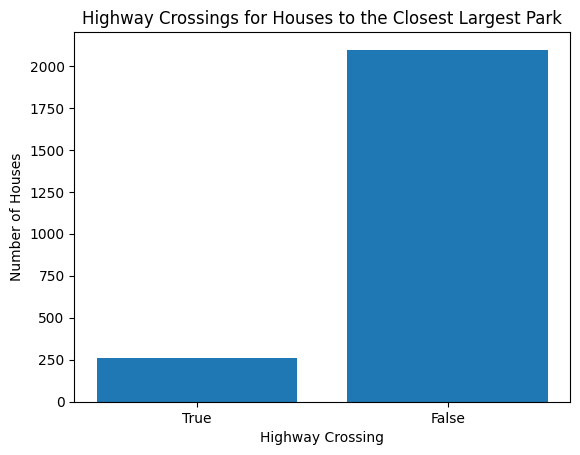

In [84]:
import matplotlib.pyplot as plt # Import the matplotlib library

# Assuming 'highwaycross' is a list of booleans, count the True and False values
heights = [highwaycross.count(True), highwaycross.count(False)]
labels = ['True', 'False']

plt.bar(labels, heights)
plt.xlabel('Highway Crossing')
plt.ylabel('Number of Houses')
plt.title('Highway Crossings for Houses to the Closest Largest Park')
plt.show()